# Feature Engineering

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import string
from nltk.corpus import stopwords
import re
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image, ImageStat
import cv2
from IPython.display import clear_output
import time
import os.path

Using TensorFlow backend.


## Set files and folders

In [2]:
data_file = r'./Data/cleaned_train.csv'
image_source = r'./Data/Images/data/competition_files/train_jpg'
data_folder = r'./Data'

## Read data

In [3]:
data = pd.read_csv(data_file)

## Numerical data

### Create price zscore per category

Intuitively, the price variable should be related to the *deal_probability*. However, as was seen in the Exploratory Data Analysis section, the relationship is far from being a linear one, and different items will have different price magnitudes.

Conditioning the price data by category should improve the information contained inthe *price* column (relative to *deal_probability*).

In [4]:
#Compute mean and standard deviation of price by category_name
cat_mean = data.groupby(['category_name']).mean().loc[:,['price']]
cat_std = data.groupby(['category_name']).std().loc[:,['price']]
cat_mean.rename(columns = {'price':'cat_price_mean'}, inplace = True)
cat_std.rename(columns = {'price':'cat_price_std'}, inplace = True)

In [5]:
#Join parent category mean and standard deviation to main table
data = pd.merge(data, cat_mean, how = 'left', left_on = 'category_name', right_index = True)
data = pd.merge(data, cat_std, how = 'left', left_on = 'category_name', right_index = True)

In [6]:
#Compute zscore
data['price_zscore'] = (data.price - data.cat_price_mean) / data.cat_price_std

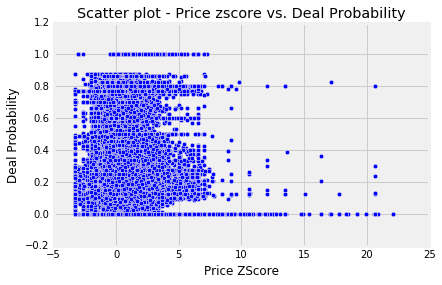

In [7]:
#Create scatter plot
plt.scatter(x = data.price_zscore, y = data.deal_probability);
plt.xlabel('Price ZScore');
plt.ylabel('Deal Probability');
plt.title('Scatter plot - Price zscore vs. Deal Probability');

In [8]:
#Copy numerical features into a new dataframe
features = data.loc[:,['price','price_zscore','item_seq_number','image_top_1']].copy()

## Categorical data

The data has multiple categorical data objects (for example: *region*, *category_name*, and *user_type*). 
In order to be able to use that information in machine learning, the unique values of each categorical feature is assigned a new column in the dataset. For each record, a "1" flags the presence of a specific value in a categorical variable.

In [9]:
reg = pd.get_dummies(data.region, prefix = 'reg')
cat = pd.get_dummies(data.category_name, prefix = 'cat')
use = pd.get_dummies(data.user_type, prefix = 'use')

An interesting aspect to explore is to assess *deal_probability* between a weekday and a weekend day. I hypothesize that during weekends, there are more users logged into the website checking the ads, generating more deals for the platform.

For this reason, I decided to extract a categorical variable from *activation_date* that identifies it as a weekday or a weekend day.

In [10]:
data['Weekday'] = data.activation_date.apply(lambda x: pd.to_datetime(x).weekday())
data['Day'] = data.Weekday.apply(lambda x: 'Weekday' if x<=4 else 'Weekend')
day = pd.get_dummies(data.Day, prefix = 'day')

In [11]:
day = pd.get_dummies(data.Day, prefix = 'day')

In [12]:
#Expand features dataframe with categorical variables
features[reg.columns] = reg
features[cat.columns] = cat
features[use.columns] = use
features[day.columns] = day

## Text data

For an ad to be effective, it has to be succinct and convey all the information that the potential buyer needs to make an informed decision. If a large quantity of capitalized letters and punctuation (example would be exclamation points) are used, or if the title/description are too long, I suspect the *deal_probability* decays, as the ad becomes similar to SPAM-like communication.

The following variables are used in order to capture clear and succinct communication:

* Proportion of capitalized letters used in *title* and *description*
* Proportion of punctuation used in *title* and *description*
* Proportion of Russian stop words used in *title* and *description*
* Length of *title*
* Length of *description*

In [13]:
#Functions to apply to dataframe text columns
def count_cap(s):
    counter = 0
    for l in s:
        if(l.isupper()):
            counter +=1
    return counter

def count_pun(s):
    counter = 0
    for l in s:
        if(l in string.punctuation):
            counter +=1
    return counter

def count_stop(s):
    stop_words = stopwords.words('russian')
    list_words = re.findall(r"[\w']+",s)
    counter = len(set(stop_words).intersection(set(list_words)))
    return counter

#Count
data['cap_nr_title'] = data.title.apply(lambda x: count_cap(x))
data['pun_nr_title'] = data.title.apply(lambda x: count_pun(x))
data['stp_nr_title'] = data.title.apply(lambda x: count_stop(x))
#Make sure that onject type in description field is a string
data.loc[pd.isnull(data.description), ['description']] = ''
#Create features
data['cap_nr_description'] = data.description.apply(lambda x: count_cap(x))
data['pun_nr_description'] = data.description.apply(lambda x: count_pun(x))
data['stp_nr_description'] = data.description.apply(lambda x: count_stop(x))
data['length_title'] = data.title.apply(lambda x: len(x))
data['length_description'] = data.description.apply(lambda x: len(x))
data['prop_caps_title'] = data.cap_nr_title / data.length_title
data['prop_caps_description'] = data.cap_nr_description / data.length_description
data['prop_pun_title'] = data.pun_nr_title / data.length_title
data['prop_pun_description'] = data.pun_nr_description / data.length_description
data['prop_stop_title'] = data.stp_nr_title / data.length_title
data['prop_stop_description'] = data.stp_nr_description / data.length_description

In [14]:
features = pd.concat([features, data.loc[:,['prop_caps_title','prop_caps_description','prop_pun_title','prop_pun_description','prop_stop_title','prop_stop_description','length_title','length_description']]], axis = 1)

## Image data

A high quality image attached to an ad is expected to increase its *deal_probability*. In this section, 3 different metrics are constructed in order to descrobe some aspect of image quality: 

* The unambiguous identification of the object the image contains: the ResNet-50 model arquitecture with pre-trained ImageNet weights was used to identify the object in the ad images provided. The highest likelihood outputted by the model is used as a metric of unambiguous object identification (example: 0.9 likelihood that the object is a chair encodes a higher quality of picture than if the highest class likelihood is 0.1).

* Image blur metric: the approach followed was taken from this website: https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/. 

* Image brightness metric: it is intuitive that photos with poor lightning convey low quality than if the image is well lit. The methodology taken here is to convert an image to grayscale, and then take the average pixel value across the photo.

In [15]:
ResNet50_model = ResNet50(weights='imagenet')
prob_list = []
blur_list = []
brightness_list = []
c = 1
if not (os.path.exists(data_folder + r'/img_metrics.csv')):
    for i in data.image[:100]:
        #Track iteration number (thousands increments)
        if c % 2 == 0:
            clear_output(wait = True)
            print(c)
            time.sleep(0.01)
        c += 1
        #If ad doesn't have an image:
        if pd.isnull(i):
            img_prob = 0
            img_blur = 0
            brightness_stat = 0
        else:
            #Image object detection probability: proxy for unamibiguous object photo
            img_path = image_source + r'/'+i+r'.jpg'
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_input = preprocess_input(img_array)
            preds = ResNet50_model.predict(img_input)
            try:
                img_prob = decode_predictions(preds, top = 1)[0][0][2]
            except:
                img_prob = 0
            #Image blur scale: approach implemented from this website -> https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            try:
                img_blur = cv2.Laplacian(img_gray, cv2.CV_64F).var()
            except:
                img_blur = 0
            #Image brightness: criteria for image quality
            img_gray = Image.open(img_path).convert('L')
            try:
                brightness_stat = ImageStat.Stat(img_gray).mean[0]
            except:
                brightness_stat = 0
            #Append photo quality metrics to corresponding lists
        prob_list.append(img_prob)
        blur_list.append(img_blur)
        brightness_list.append(brightness_stat)
    #Aggregate image metrics into a dataframe
    img_metrics = pd.DataFrame({'object_prob':prob_list,'img_blur': blur_list,'img_brightness': brightness_list})
    img_metrics.to_csv(data_folder + r'/img_metrics.csv')
else:
    img_metrics = pd.read_csv(data_folder + r'/img_metrics.csv', index_col = 0)

C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Cleaning features

Check which features has at least 1 *nan* value.

In [16]:
features.columns[features.isna().any()]

Index(['image_top_1', 'prop_caps_description', 'prop_pun_description',
       'prop_stop_description'],
      dtype='object')

*nan* values will be replaced by zero as the replacement is necessary for machine learning algos (Example in regression, all values must be defined).

This replacement does not contradict the meaning of the variable: 

* When *image_top_1* is missing it means that there is no picture for the ad

* The other columns (*prop_caps_description*, *prop_pun_description*, and *prop_stop_description*) have *nan* values as a result of division by zero when there are no cases of capitalized letters, use of punctuation, or stop words in the description of the ad. It follows that if such cases are not present, a replacement by zero is appropriate.

In [17]:
features.fillna(0, inplace = True)

## Features and targets table construction

In [18]:
features = pd.concat([features, img_metrics], axis = 1)

In [19]:
features_targets = pd.concat([features, data.loc[:,['deal_probability']]], axis = 1)
#Add binary target variable for classification-type problems
features_targets['deal_binary'] = 0.0
features_targets.loc[features_targets.deal_probability >= 0.5,['deal_binary']] = 1.0

In [20]:
#Save csv with features and targets ready to be used in a machine learning pipeline
features_targets.to_csv(data_folder + r'./features_targets.csv')